In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from scipy.stats import ks_2samp

from cuhk_sysu_pedes.build import build_annotations

In [2]:
sns.set_theme()

In [3]:
# Load annotations
data_folder = Path.cwd() / "data"
annos = build_annotations(str(data_folder / "CUHK-SYSU"), str(data_folder / "CUHK-PEDES"))
annos.head()

split_pedes  \
person_id frame_id               
1         1              train   
          2              train   
          3              train   
2         1              train   
          2              train   

                                                            caption_1  \
person_id frame_id                                                      
1         1         A man wearing a red shirt with a picture on it...   
          2         He has  dark black  hair   and is  wearing a  ...   
          3         The man is wearing a red shirt and black jeans...   
2         1         A man wearing a tight pink tank top, a pair of...   
          2         He is wearing blue shorts and white tennis sho...   

                                                            caption_2  \
person_id frame_id                                                      
1         1         The man has short black hair. He is wearing a ...   
          2         The man is wearing light colored shoes, bright...   
          3         The man has short, black hair. He is wearing d...   
2         1         The man has short, black hair. He is wearing s...   
          2         A man wears a white tank top over deep-blue sh...   

                   split_sysu  is_hard  bbox_x  bbox_y  bbox_w  bbox_h  
person_id frame_id                                                      
1         1             train    False     391     243      37     112  
          2             train     True     195     274      51     142  
          3             train    False     250     241      92     247  
2         1             train    False     426     249      42     118  
          2             train    False     204     278      55     148

In [4]:
# Create SYSU splits of interest
sysu = annos[annos.split_sysu.notna()]

sysu_train = sysu.query("split_sysu == 'train'")
sysu_train_reid = sysu_train[sysu_train.index.get_level_values("person_id") != -1]
sysu_train_detections = sysu_train[sysu_train.index.get_level_values("person_id") == -1]

sysu_test = sysu.query("split_sysu != 'train'")
sysu_test_samples = sysu_test.groupby("person_id")
sysu_test_annotations = sysu_test.dropna()
sysu_test_distractor = sysu_test[sysu_test.isna()]

In [5]:
# Create PEDES splits of interest
pedes = annos[annos.split_pedes.notna()]

pedes_train = pedes.query("split_pedes == 'train'")
pedes_test = pedes.query("split_pedes == 'test'")
pedes_val = pedes.query("split_pedes == 'val'")

# Corruption from merging split

The CUHK-SYSU-PEDES dataset aims to train Text Detection ReID model. Although, the base tasks, Text ReID and Detection ReID, have their respective datasets, CUHK-PEDES and CUHK-SYSU, with different train/test splits. It means that we need to design new splits for the merged new merged dataset.

The [first part](#show-corruption-of-simple-merge) aims to show that the test split of PEDES and SYSU contain **a lot** of the train annotations from the other dataset.

The [second part](#base-split-on-pedes) shows the stats if we keep PEDES split. The reasons are detailed in the section. Also we provided some comparisons with the original SYSU test split.
                  
The [conclusion](#conclusion-of-the-original-problem) gives an answer to the [issue](https://gricad-gitlab.univ-grenoble-alpes.fr/reusm/cuhk-sysu-pedes/-/issues/17#note_235286) raised about the split conflict.

## Show corruption of simple merge

In this part we will shows the number of overlap between the test set of both databases with the train split of the other dataset.

We conclude that most of the test annotations from one database is part of the database of the other database. So we cannot keep the current splits as such.

### PEDES test annotations contain a lot of SYSU train annotations

In [6]:
n_pedes_test = pedes_test.shape[0]
n_pedes_test_train_sysu = pedes_test.query("split_sysu == 'train'").shape[0]
n_pedes_test_test_sysu = pedes_test.query("split_sysu != 'train'").shape[0]

print(
    f"PEDES test samples: {n_pedes_test:,d}\n"
    f"PEDES test samples (train SYSU): {n_pedes_test_train_sysu:,d}, "
        f"{n_pedes_test_train_sysu/n_pedes_test:.2%} <- of PEDES test samples\n"
    f"PEDES test samples (test SYSU): {n_pedes_test_test_sysu:,d}"
)

PEDES test samples: 1,763
PEDES test samples (train SYSU): 1,110, 62.96% <- of PEDES test samples
PEDES test samples (test SYSU): 653


### SYSU test annotations contain a lot of PEDES train annotations

SYSU test annotations can be seen as [individual annotations](#sysu-test-annotations) or as sample annotations (query + gallery for one person ID). We show the mix of train/split in both cases.

#### SYSU test annotations

In [7]:
# Annotations level (we do not take into account query/gallery property)
n_sysu_test = sysu_test_annotations.shape[0]
n_sysu_test_train_pedes = sysu_test_annotations.query("split_pedes == 'train'").shape[0]
n_sysu_test_test_pedes = sysu_test_annotations.query("split_pedes == 'test'").shape[0]

print(
    f"SYSU test annotations: {n_sysu_test:,d}\n"
    f"SYSU test annotations (train PEDES): {n_sysu_test_train_pedes:,d}\n"
    f"SYSU test annotations (test PEDES): {n_sysu_test_test_pedes:,d}\n"
    f"Test annotations seen by D-ReID: {n_sysu_test_train_pedes:,d}"
        f" ({n_sysu_test_train_pedes/n_sysu_test:.2%})\n"
)

SYSU test annotations: 8,341
SYSU test annotations (train PEDES): 7,056
SYSU test annotations (test PEDES): 653
Test annotations seen by D-ReID: 7,056 (84.59%)



#### SYSU test samples

A sample is a query annotations and 100 gallery elements. Some of the gallery elements have annotations, most of them have no annotations: they are distractor frames.

A sample is considered to be **corrupted** if one of its annotations is used in PEDES train split.

In [8]:
def is_corrupted(sample: DataFrame) -> bool:
    return sample.split_pedes.value_counts().get('train', 0) > 0

In [9]:
n_sysu_test_samples = len(sysu_test_samples)
n_sysu_test_samples_corrupted = sysu_test_samples.apply(is_corrupted).sum()

print(
    f"SYSU test samples: {n_sysu_test_samples:,d}\n"
    f"SYSU test samples corrupted: {n_sysu_test_samples_corrupted:,d}, "
        f"{n_sysu_test_samples_corrupted/n_sysu_test_samples:.2%} <- of SYSU test samples\n"
)

SYSU test samples: 2,900
SYSU test samples corrupted: 2,450, 84.48% <- of SYSU test samples



## Base split on PEDES

We would like to base our split on PEDES for several reasons:

- We do not want to loose training captions since we already have a subset of the original PEDES dataset, we only took from PEDES the samples which are in SYSU. So we do not want to reduce the captions information more.
- The PEDES evaluation heavily relies on the number of the annotations in the dataset.
- The SYSU test set is not affected by less annotations since the test samples has a fixed gallery size of 100
- (shown below) The SYSU train set is slightly reduced.
- (shown below) The SYSU test set is reduced by a reasonable amount.
- (shown below) The PEDES train samples have no NA values, so we can train a Text ReID model on it.

### PEDES split stats

We verify that PEDES annotations has no NA values. NA values in PEDES annotations would indicate that some annotations are missing SYSU annotations.

We have an annotations comparison between PEDES and SYSU train and test splits. We only consider SYSU ReID annotations in this section (no detections annotations from train split and no distractor from test split).

Eventually, we have a look at PEDES validation set, SYSU has no validation set. So we prefer to add the validation set to the training set.

In [10]:
pedes_has_na = pedes.isna().any(axis=1).any()

print(f"PEDES has NA annotations: {pedes_has_na}")

PEDES has NA annotations: False


#### PEDES validation set

What can we do with the validation samples of PEDES? There are no NA value inside it so it makes it usable for test and training set. 

Since validation set is usually used to fit the hyperparameters during training, we prefer to add it to the training samples. TD ReID model can perform their own cross validation on the training set, if needed. 

In [11]:
n_pedes_val = len(pedes_val)
n_pedes_val_sysu_train = len(pedes_val.query("split_sysu == 'train'"))
n_pedes_val_sysu_test = len(pedes_val.query("split_sysu != 'train'"))
n_pedes_val_na = pedes_val.isna().any(axis=1).sum()

print(
    f"PEDES validation split: {n_pedes_val:,d}\n"
    f"PEDES validation split (SYSU train): {n_pedes_val_sysu_train:,d}, "
        f"{n_pedes_val_sysu_train/n_pedes_val:.2%} <- over PEDES validation set\n"
    f"PEDES validation split (SYSU test): {n_pedes_val_sysu_test:,d}, "
        f"{n_pedes_val_sysu_test/n_pedes_val:.2%} <- over PEDES validaton set\n"
    f"PEDES validation NA: {n_pedes_val_na}"
)

PEDES validation split: 1,766
PEDES validation split (SYSU train): 1,134, 64.21% <- over PEDES validation set
PEDES validation split (SYSU test): 632, 35.79% <- over PEDES validaton set
PEDES validation NA: 0


#### PEDES VS SYSU (train/test)

**NOTE**: We consider PEDES train split as the union of original train and validation splits.

We can see that PEDES has a bigger train set compared to SYSU. Thus, SYSU has a bigger test set. 

As we said earlier, this is not a *big* problem. SYSU test set are composed of samples (one sample = 1 unique person ID), so *if we reduce the number of samples it would only reduce the number of samples to evaluate*. This number is still high, so it's ok. Each gallery evaluation would remain the same: 1 query for 100 gallery frames. More details about the comparison [here](#comparison-with-sysu-test-querygallery).

Plus, if we reduced the number of test samples of PEDES, it would bias the test evaluation itself, since the test gallery size depends of the number of annotations.

In [12]:
pedes_has_overlap_train_val = not pedes_val.index.intersection(pedes_train.index).empty

print(f"PEDES has overlap between its train and val splits: {pedes_has_overlap_train_val}")

PEDES has overlap between its train and val splits: False


In [35]:
n_pedes_train = pedes_train.shape[0] + pedes_val.shape[0]
n_pedes_test = pedes_test.shape[0]

n_sysu_train_reid = sysu_train_reid.shape[0]
n_sysu_test_annotations = sysu_test_annotations.shape[0]

print(
    f"PEDES train annotations: {n_pedes_train:,d}\n"
    f"SYSU train annotations: {n_sysu_train_reid:,d}\n"
    f"{'':-^30s}\n"
    f"PEDES test annotations: {n_pedes_test:,d}\n"
    f"SYSU test annotations: {n_sysu_test_annotations:,d}\n"
)

PEDES train annotations: 21,658
SYSU train annotations: 15,080
------------------------------
PEDES test annotations: 1,763
SYSU test annotations: 8,341



In [14]:
n_pedes_train_person_ids = (
    pedes_train.index.get_level_values("person_id").unique().size
    + pedes_val.index.get_level_values("person_id").unique().size
)
n_pedes_test_person_ids = pedes_test.index.get_level_values("person_id").unique().size

n_sysu_train_reid_person_ids = sysu_train_reid.index.get_level_values("person_id").unique().size
n_sysu_test_annotations_person_ids = sysu_test_annotations.index.get_level_values("person_id").unique().size

print(
    f"PEDES train person IDs: {n_pedes_train_person_ids:,d}\n"
    f"SYSU train person IDs: {n_sysu_train_reid_person_ids:,d}\n"
    f"{'':-^30s}\n"
    f"PEDES test person IDs: {n_pedes_test_person_ids:,d}\n"
    f"SYSU test person IDs: {n_sysu_test_annotations_person_ids:,d}"
)

PEDES train person IDs: 7,791
SYSU train person IDs: 5,532
------------------------------
PEDES test person IDs: 641
SYSU test person IDs: 2,900


### Stats of the new splits

### Training set

For the training set we need to have the PEDES (ReID) train and validation ([see](#pedes-validation-set)) annotations. Plus, we need the detections annotations from SYSU, the ones without ReID annotations.

In [15]:
train_set_reid = annos.query("split_pedes in ('train', 'val')")
train_set_detections = sysu_train_detections

reid_and_detections_overlap = not train_set_reid.index.intersection(train_set_detections.index).empty

print(f"ReID annotations overlap with detections annotations: {reid_and_detections_overlap}")

ReID annotations overlap with detections annotations: False


In [16]:
train_set = pd.concat(
    [train_set_reid, train_set_detections],
)

n_train_set_reid = len(train_set_reid)
n_train_set_detections = len(train_set_detections)
n_train_set = len(train_set)

print(
    f"Train set (ReID): {n_train_set_reid:,d}\n"
    f"Train set (Detections): {n_train_set_detections:,d}\n"
    f"Train set (ReID + Detections): {n_train_set_reid+n_train_set_detections:,d}\n"
    f"Train set (All): {n_train_set:,d}\n"
)

Train set (ReID): 21,658
Train set (Detections): 40,186
Train set (ReID + Detections): 61,844
Train set (All): 61,844



### Test set

The test set is the PEDES test set. So we take all the person IDs in PEDES test set and they will be the base of the person IDs for the new test set.

*Reminder*: the test set should have the ReID annotations to perform T-ReID evaluation and also have samples-shaped annotations to perform D-ReID evaluation.


#### Distractor and samples' completness

Some person IDs in the PEDES test set are included in the SYSU test set. For those samples, we already have 101 (1 query + 100 gallery) rows *i.e.* a sample.

For the rest of them, which are not included in the SYSU test set, we only have the annotations (detections + captions) and we do not have distractor, we will need to build them. (will be implemented in code).


In [17]:
pedes_test_person_ids = pedes_test.index.get_level_values("person_id").unique()
test_set = annos.loc[pedes_test_person_ids]

In [18]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24340 entries, (15, 29) to (5916, 1753)
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   split_pedes  1763 non-null   category
 1   caption_1    1763 non-null   object  
 2   caption_2    1763 non-null   object  
 3   split_sysu   24340 non-null  category
 4   is_hard      24340 non-null  bool    
 5   bbox_x       1763 non-null   UInt16  
 6   bbox_y       1763 non-null   UInt16  
 7   bbox_w       1763 non-null   UInt16  
 8   bbox_h       1763 non-null   UInt16  
dtypes: UInt16(4), bool(1), category(2), object(2)
memory usage: 1.8+ MB


In [24]:
test_set_annotations = test_set.dropna()
test_set_distractor = test_set[test_set.isna()]

n_test_set_annotations = len(test_set_annotations)
n_test_set_distractor = len(test_set_distractor)

print(
    f"Test set (annotations): {n_test_set_annotations:,d}\n"
    f"Test set (distractor): {n_test_set_distractor:,d}"
)

Test set (annotations): 1,763
Test set (distractor): 24,340


In [25]:
n_test_set_by_person_id = test_set.groupby("person_id").apply(len)
n_test_set_by_person_id.name = "n_annotations"
n_test_set_by_person_id = n_test_set_by_person_id.to_frame()

n_test_set_by_person_id_with_complete_samples = n_test_set_by_person_id.query("n_annotations == 101")
n_test_set_by_person_id_with_incomplete_samples = n_test_set_by_person_id.query("n_annotations < 101")

print(
    f"Compelte samples: {n_test_set_by_person_id_with_complete_samples.size:,d}\n"
    f"Incompelte samples: {n_test_set_by_person_id_with_incomplete_samples.size:,d}\n"
)

Compelte samples: 230
Incompelte samples: 411



In [26]:
n_test_set_by_person_id_with_incomplete_samples.describe()

n_annotations
count      411.00000
mean         2.70073
std          1.06861
min          2.00000
25%          2.00000
50%          2.00000
75%          3.00000
max         10.00000

#### Comparison with SYSU test query/gallery

We will compare the annotations between our new test set and SYSU test set. We will ignore the distractor elements in galleries. We only focus on the number of annotations by person IDs.

We will have two distributions of annotations by person ID, one for the new test set and another one for the SYSU test set.

After some visualization and a Kolmogorov-Smirnov test, we can conclude that those distributions are not the same at all. From the histograms, we can see that the SYSU test has far more count annotations. Although, we can assert that the new evaluation is kind of similar. But it is **less statistically** significative.

The flaw of the SYSU test set (D-ReID evaluation) is the cost of aligning split. But, this is the best solution given the situation.

In [28]:
test_set_annotations_by_person_id = test_set_annotations.groupby("person_id")
n_test_set_annotations_by_person_id = test_set_annotations_by_person_id.apply(len)
n_test_set_annotations_by_person_id.describe()

count    641.000000
mean       2.750390
std        1.108252
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       10.000000
dtype: float64

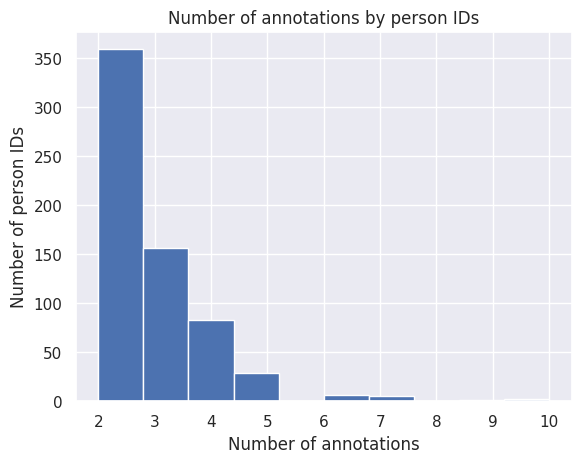

In [29]:
plt.figure()
n_test_set_annotations_by_person_id.hist()
plt.title("Number of annotations by person IDs")
plt.xlabel("Number of annotations")
plt.ylabel("Number of person IDs")
plt.show()

We can compare these stats to the original SYSU query/gallery annotations distributions.

In [30]:
sysu_test_annotations_by_person_id = sysu_test_annotations.groupby("person_id")
n_sysu_test_annotations_by_person_id = sysu_test_annotations_by_person_id.apply(len)
n_sysu_test_annotations_by_person_id.describe()

count    2900.000000
mean        2.876207
std         1.334727
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        14.000000
dtype: float64

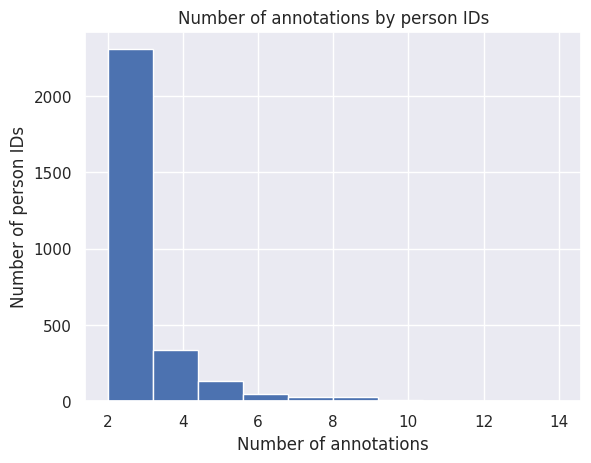

In [31]:
plt.figure()
n_sysu_test_annotations_by_person_id.hist()
plt.title("Number of annotations by person IDs")
plt.xlabel("Number of annotations")
plt.ylabel("Number of person IDs")
plt.show()

In [ ]:
all_annotations_by_person_id = pd.concat([
    n_test_set_annotations_by_person_id,
    n_sysu_test_annotations_by_person_id,
])
mean = all_annotations_by_person_id.mean()
std = all_annotations_by_person_id.std()

n_test_set_annotations_by_person_id_standardized = (n_test_set_annotations_by_person_id - mean) / std
n_sysu_test_annotations_by_person_id_standardized = (n_sysu_test_annotations_by_person_id - mean) / std

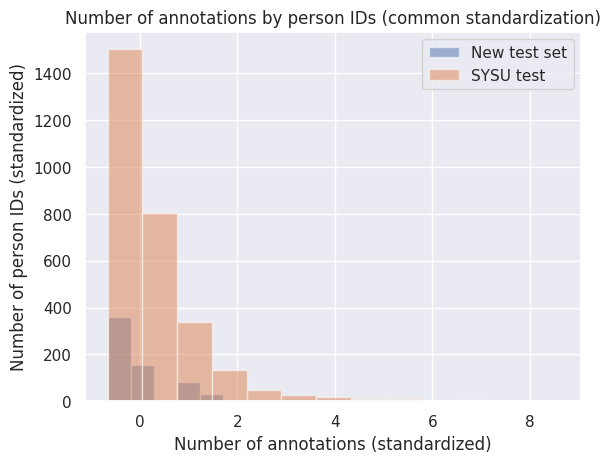

In [ ]:
n_bins = len(n_sysu_test_annotations_by_person_id_standardized.unique())
plt.figure()

n_test_set_annotations_by_person_id_standardized.hist(bins=n_bins, alpha=.5, label='New test set')
n_sysu_test_annotations_by_person_id_standardized.hist(bins=n_bins, alpha=.5, label='SYSU test')

plt.title("Number of annotations by person IDs (common standardization)")
plt.xlabel("Number of annotations (standardized)")
plt.ylabel("Number of person IDs (standardized)")
plt.legend()

plt.show()

In [ ]:
# Assuming df1 and df2 are your DataFrames

# Perform Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(
    n_sysu_test_annotations_by_person_id.to_numpy().flatten(),
    n_test_set_annotations_by_person_id.to_numpy().flatten()
)

print(f"KS Statistic: {statistic:.2%}, P-value: {p_value:.2%}")


KS Statistic: 4.18%, P-value: 30.85%


In [ ]:
def is_greater(threshold: int, series: pd.Series) -> float:
    return series[series > threshold].size / series.size

In [ ]:
thresholds = range(3, 10)
percentages_greater_than_threshold_sysu_test = [
    is_greater(threshold, n_sysu_test_annotations_by_person_id)
    for threshold in thresholds
]

percentages_greater_than_threshold_test_set = [
    is_greater(threshold, n_test_set_annotations_by_person_id)
    for threshold in thresholds
]


In [ ]:
thresholds = range(3, 10)
ns_greater_than_threshold_sysu_test = [
    percentage * len(sysu_test_annotations_by_person_id)
    for percentage in percentages_greater_than_threshold_sysu_test
]

ns_greater_than_threshold_test_set = [
    percentage * len(test_set_annotations_by_person_id)
    for percentage in percentages_greater_than_threshold_test_set
]


In [ ]:
def plot_comparison(
    thresholds: list[int],
    sysu_test_values: list[float|int],
    test_set_values: list[float|int],
    x_label: str,
    y_label: str,
    title: str,
    i_seperation: int,
    tick_y: mticker.Formatter | None = None,
):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    ax1.scatter(thresholds[:i_seperation], sysu_test_values[:i_seperation], label="SYSU test")
    ax1.scatter(thresholds[:i_seperation], test_set_values[:i_seperation], label="New test set")
    ax1.set_title(title)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    if tick_y:
        ax1.yaxis.set_major_formatter(tick_y)


    ax2.scatter(thresholds[i_seperation:], sysu_test_values[i_seperation:], label="SYSU test")
    ax2.scatter(thresholds[i_seperation:], test_set_values[i_seperation:], label="New test set")
    ax2.set_title(title)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    if tick_y:
        ax2.yaxis.set_major_formatter(tick_y)

    figure.tight_layout()
    figure.subplots_adjust(wspace=.3)

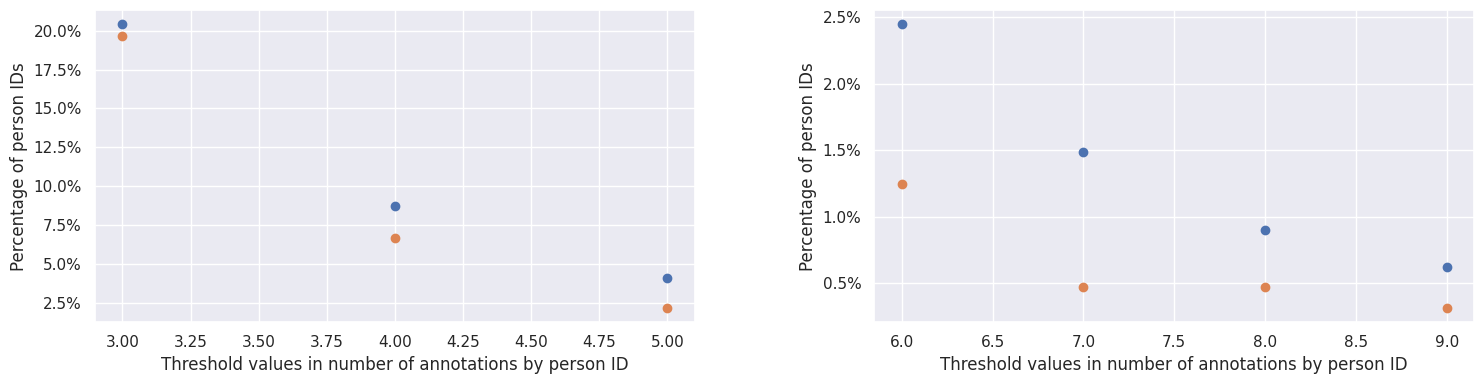

In [ ]:
x_label = "Threshold values in number of annotations by person ID"
y_label = "Percentage of person IDs"
percentage_formatter = mticker.PercentFormatter(xmax=1, decimals=1)
i_seperation = 3

plot_comparison(
    list(thresholds),
    percentages_greater_than_threshold_sysu_test,
    percentages_greater_than_threshold_test_set,
    x_label,
    y_label,
    "",
    i_seperation,
    percentage_formatter,
)

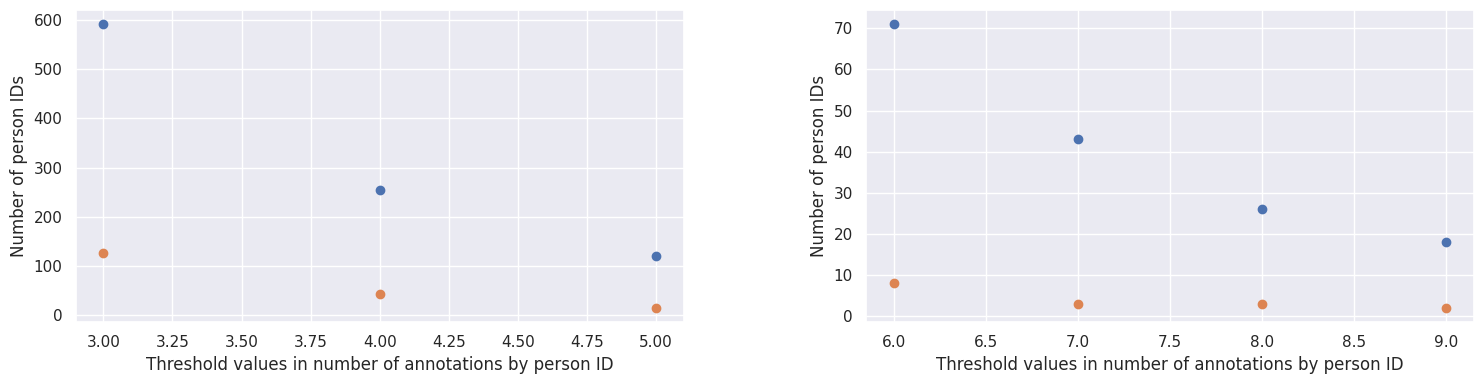

In [ ]:
y_label = "Number of person IDs"

plot_comparison(
    list(thresholds),
    ns_greater_than_threshold_sysu_test,
    ns_greater_than_threshold_test_set,
    x_label,
    y_label,
    "",
    i_seperation,
)

### Overlap check

We are checking if there are person IDs overlap between the different splits. We can see that PEDES, SYSU and the new dataset does not have overlap in person IDs.

We can also check the correct merge of train and validation of PEDES.

In [ ]:
# General index overlap
train_index = train_set.index
test_index = test_set.index

has_overlap = not train_index.intersection(test_index).empty
print(f"Train and test split has overlap: {has_overlap}")

Train and test split has overlap: False


In [ ]:
def print_person_ids(train_set: DataFrame, test_set: DataFrame, dataset_name: str) -> None:
    train_person_ids = train_set.index.get_level_values("person_id").unique()
    test_person_ids = test_set.index.get_level_values("person_id").unique()
    shared_person_ids = train_person_ids.intersection(test_person_ids)

    n_train_person_ids = len(train_person_ids)
    n_test_person_ids = len(test_person_ids)
    n_shared_person_ids = len(shared_person_ids)

    print(
        f"Dataset: {dataset_name}\n"
        f"Train person IDs: {n_train_person_ids:,d}\n"
        f"Test person IDs: {n_test_person_ids:,d}\n"
        f"Shared person IDs: {n_shared_person_ids}\n"
        f"{'':-^30s}"
    )

In [ ]:
print_person_ids(pedes_train, pedes_test, "PEDES")
print_person_ids(sysu_train, sysu_test_annotations, "SYSU")
print_person_ids(train_set, test_set_annotations, "New dataset")

n_person_ids_pedes_train = pedes_train.index.get_level_values("person_id").unique().size
n_person_ids_pedes_val = pedes_val.index.get_level_values("person_id").unique().size
n_person_ids_pedes_train_val = n_person_ids_pedes_train + n_person_ids_pedes_val

n_person_ids_train_set = train_set_reid.index.get_level_values("person_id").unique().size

print(
    f"PEDES train samples + validation samples: "
        f"{n_person_ids_pedes_train:,d} + {n_person_ids_pedes_val:,d} = {n_person_ids_pedes_train_val:,d}\n"
    f"New train samples: {n_person_ids_train_set:,d}"
)

Dataset: PEDES
Train person IDs: 7,150
Test person IDs: 641
Shared person IDs: 0
------------------------------
Dataset: SYSU
Train person IDs: 5,533
Test person IDs: 2,900
Shared person IDs: 0
------------------------------
Dataset: New dataset
Train person IDs: 7,792
Test person IDs: 641
Shared person IDs: 0
------------------------------
PEDES train samples + validation samples: 7,150 + 641 = 7,791
New train samples: 7,791


We have more training samples than PEDES because we added the validation set to the training set

In [ ]:
pedes_test_by_person_ids = pedes_test.groupby("person_id")
n_annotations_by_person_ids = pedes_test_by_person_ids.apply(len)
n_annotations_by_person_ids.describe()

count    641.000000
mean       2.750390
std        1.108252
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       10.000000
dtype: float64

## Conclusion of the original problem

In the [section about the corruption](#corruption-from-merging-split), we showed that we cannot keep smaller pure train/test splits. Namely, we cannot only keep annotations which are not corrupted, it would reduce too badly.

Thus, we should choose one dataset split to align the other dataset split. PEDES is already reduced, because we kept PEDES annotations. Plus, we consider that we need enough annotations for training the Text-Image alignment of features. As we have seen [earlier](#pedes-vs-sysu-traintest), if we choose SYSU we will lose a lot of training samples. We suppose that the TD task will be more challenging to learn. So, we prefer to maximize the training samples.



Although, if we pick PEDES split, there are main drawbacks that we identified in this report:

1. Vanilla T-ReID model (trained and evaluated on original PEDES) cannot directly compared to T-ReID model trained and evaluated on PEDES. Because we took a subset of PEDES samples. Since SYSU does not have its vanilla splits, D-ReID model has the same faith, we cannot directly transfer their performance on original SYSU to this dataset. **To compare existing models on T-ReID and D-ReID tasks, we need to train them on CUHK-SYSU-PEDES**. Thus, we would need some benchmark to quantify the gap between CUHK-SYSU-PEDES and the base dataset. We suppose that the gap would not be that big.
2. The SYSU test set is "*damaged*" by the change in split. **There are less than 4x samples and annotations**. Luckily, the gallery sizes remain at 100. Although, we observed that there are **less small true positives in each gallery**. This makes the D-ReID evaluation less significant and challenging. Plus, the current D-ReID models' scores are quite high on SYSU already, so it would be difficult to properly order the model.



Based on these drawbacks, we can forecast the future use of TD-ReID model:

1. We can compare the TD-models on new dataset (PRW, ICFG-PEDES, RTSP-ReID) in a **total unsupervised fashion**. Since we make the hypothesis of the TD-ReID would be more robust based on their dual-task dual-modality method. 
2. **CUHK-SYSU-PEDES remains a relevant dataset** to learn the joint task of TD-ReID which is more practical than T-ReID model and D-ReID model seperated. Even if the D-ReID evaluation is flawed compared to vanilla evaluation on SYSU, there are enough annotations to have a correct prediction of the performance of the model.